In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pymc as pm
from tqdm import tqdm
import emcee
from scipy.stats import norm, truncnorm
import corner

In [82]:
data = np.genfromtxt('../data/data_yerr.dat', names=True, comments='#', delimiter='&')
data

array([( 1., 201., 592., 61.), ( 2., 244., 401., 25.),
       ( 3.,  47., 583., 38.), ( 4., 287., 402., 15.),
       ( 5., 203., 495., 21.), ( 6.,  58., 173., 15.),
       ( 7., 210., 479., 27.), ( 8., 202., 504., 14.),
       ( 9., 198., 510., 30.), (10., 158., 416., 16.),
       (11., 165., 393., 14.), (12., 201., 442., 25.),
       (13., 157., 317., 52.), (14., 131., 311., 16.),
       (15., 166., 400., 34.), (16., 160., 337., 31.),
       (17., 186., 423., 42.), (18., 125., 334., 26.),
       (19., 218., 533., 16.), (20., 146., 344., 22.)],
      dtype=[('index', '<f8'), ('x', '<f8'), ('y', '<f8'), ('sigm_y', '<f8')])

In [83]:
x = data['x']  
y = data['y']
sigma_y = data['sigm_y']

In [84]:
def build_model(m, b):
    def model(x):
        return m * x + b
    return model

def lnlikelihood(m, b, x=data['x'], y=data['y'], sigma_y=sigma_y):
    model = build_model(m, b)
    lnlike = -0.5 * np.sum(np.log(2 * np.pi * sigma_y**2)) - np.sum((y - model(x))**2 / (2 * sigma_y**2))
    return lnlike

def prior(m, b):
    return 1

initial_m = 2
initial_b = 100

m = initial_m
b = initial_b

p_current = lnlikelihood(m, b)

chain_m = [m]
chain_b = [b]
probs = [p_current]

In [85]:
niter = 1000000
for i in range(niter):
    samples = []
    m_proposed = norm.rvs(loc=m, scale=2)  
    b_proposed = norm.rvs(loc=b, scale=100)  

    p_p = lnlikelihood(m_proposed, b_proposed)
    
    
    α = np.exp(p_p - p_current) 
    u = np.random.uniform()
    accepted = u < α
    
    if accepted:
        m, b = m_proposed, b_proposed
        p_current = p_p
        
    chain_m.append(m)
    chain_b.append(b)
    probs.append(p_current)

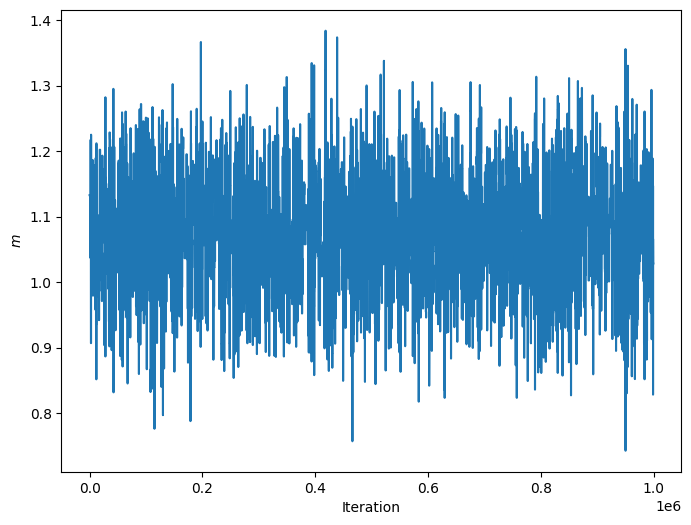

In [86]:
burnin_length = 1000

plt.figure(figsize=(8, 6))
plt.plot(chain_m[burnin_length:])
plt.xlabel('Iteration')
plt.ylabel('$m$')
plt.show()

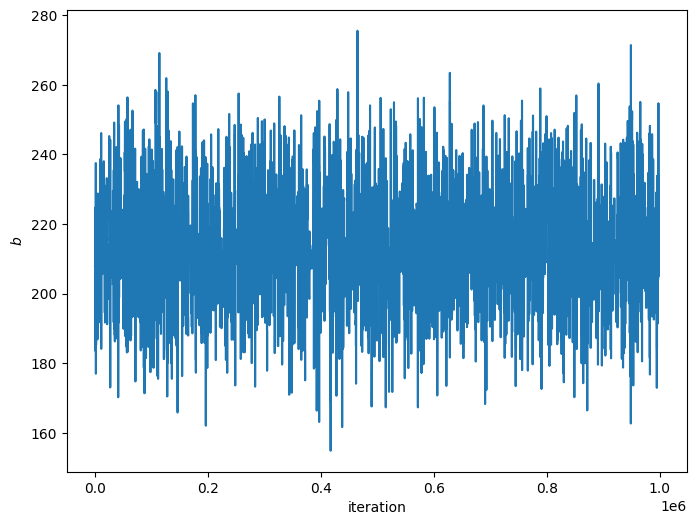

In [87]:
burnin_length = 2000

plt.figure(figsize=(8, 6))
plt.plot(chain_b[burnin_length:])
plt.xlabel('iteration')
plt.ylabel('$b$');

In [88]:
chain_m = np.array(chain_m)
chain_b = np.array(chain_b)
chain_data = np.column_stack((chain_m, chain_b, probs))
print(chain_data)

[[   2.          100.         -354.18090647]
 [   1.08516682  277.31981454 -326.30264656]
 [   1.08516682  277.31981454 -326.30264656]
 ...
 [   1.02819791  217.16808544 -227.99352358]
 [   1.02819791  217.16808544 -227.99352358]
 [   1.02819791  217.16808544 -227.99352358]]


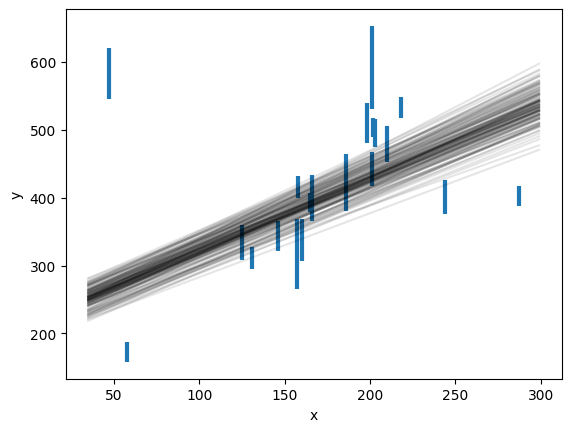

In [96]:
plt.errorbar(data['x'], data['y'], yerr=data['sigm_y'], linewidth=0, elinewidth=3, label='Data')
plt.xlabel('x')
plt.ylabel('y')

xlow, xhigh = plt.xlim()
test_x = np.linspace(xlow, xhigh, 125)

for _ in range(125):  
    m_sample = np.random.choice(chain_m)
    b_sample = np.random.choice(chain_b)
    
    model = lambda x: m_sample * x + b_sample
    predictions = model(test_x)

    plt.plot(test_x, predictions, color='black', alpha=0.1)

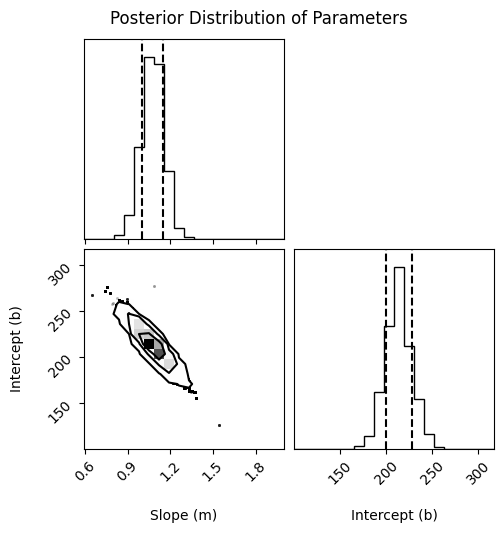

In [90]:
fig = corner.corner(np.vstack((chain_m, chain_b)).T, 
                     labels=["Slope (m)", "Intercept (b)"], 
                     quantiles=(0.16, 0.84), 
                     levels=(0.68, 0.95, 0.997))
fig.suptitle("Posterior Distribution of Parameters")
plt.show()


Text(0.5, 1.0, '2D Posterior Density of m and b')

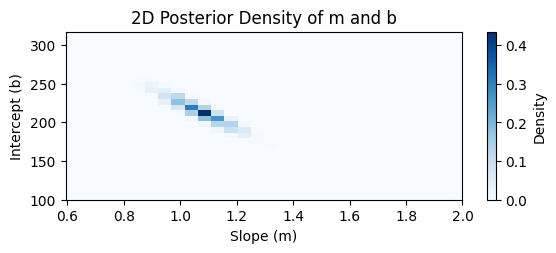

In [91]:
plt.subplot(2, 1, 1)
plt.hist2d(chain_m, chain_b, bins=30, cmap='Blues', density=True)
plt.colorbar(label='Density')
plt.xlabel('Slope (m)')
plt.ylabel('Intercept (b)')
plt.title('2D Posterior Density of m and b')